In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torchvision.transforms.functional as FT
import matplotlib.pylab as plt
from torch import nn
import torch.nn.functional as F
import tqdm
import torchvision
from matplotlib.patches import Rectangle, Circle
from sklearn.model_selection import TimeSeriesSplit, train_test_split
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")
from engine import train_one_epoch, evaluate

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Interplate the location of some not showing in the frame

In [ ]:
def interpolate_label(label, method='linear', **kwags):
    '''
    Interpolate labels using last and next frame infomation.

    Args:
        label: Ground truth tensor with columns ['frame','id','bb_left','bb_top','bb_width','bb_height','x','y','z']
        method: Interpolation method.

    Return:
        new_label: Ground truth tensor after fixing missing label by interpolating. ['frame','id','bb_left','bb_top','bb_width','bb_height','x','y','z']
    '''

    # Create full index list to facilitate the merge operation. Merge to get missing index of some objects in some frames.
    n_obj = np.unique(label.id).shape[0] # number of objects
    n_frame = np.unique(label.frame).shape[0] # number of frames
    columns = label.columns
    tempt = pd.DataFrame([i for i in range(n_obj)] * n_frame,columns=['id_x'])
    tempt['frame'] = [i+1 for i in range(n_frame) for _ in range(n_obj)]

    # Merge and interpolate missing data.
    new_label = pd.merge(tempt, label, right_on=['frame','id'],left_on=['frame','id_x'],how='left').sort_values(['id_x','frame']) # idx_x is true label without nan
    new_label.drop('id',axis=1, inplace=True)
    new_label.rename(columns={'id_x':'id'},inplace=True)
    new_label = new_label.groupby('id').apply(lambda x: x.interpolate(method=method, **kwags)).reset_index(drop=True).sort_values(['frame','id']).reset_index(drop=True).reindex(columns,axis=1)
    return new_label

### Contruct dataset for object dectection

In [ ]:
class VideoDataset(Dataset):
    '''Dataset for frame image and corresponding labels'''
    def __init__(self, annotations_file, img_dir, target_object, interpolation, transform_img_target=None, transform=None, target_transform=None):
        '''
        Initialize parameters.

        Args:
            annotations_file: Groud truth file path.
            img_dir: video image file directory.
            target_object: Objects interested through all the frames.
            interpolation: Ture or False. Whether to do interpolation or not.

        Return:
            image: tensor
            label: 'id', 'cx', 'cy','w', 'h'
        '''
        # Load labels.
        self.img_labels = pd.read_csv(annotations_file, header=None) # ['frame', 'id', 'bb_left', 'bb_top','bb_width', 'bb_height', 'x', 'y', 'z']
        self.img_labels.iloc[:,2] = self.img_labels.iloc[:,2] + self.img_labels.iloc[:,4]/2 # central x
        self.img_labels.iloc[:,3] = self.img_labels.iloc[:,3] + self.img_labels.iloc[:,5]/2 # central y
        columns = ['frame', 'id', 'cx', 'cy','w', 'h', 'x', 'y', 'z']
        self.img_labels.columns = columns
        self.img_labels.drop(['x','y','z'],inplace=True,axis=1)
        # Interpolate missing labels.
        self.img_labels = interpolate_label(self.img_labels) if interpolation else self.img_labels
        # Select target objects which we are interested in.
        self.target_object = target_object
        if target_object:
            self.img_labels = self.img_labels[self.img_labels.id.isin(target_object)]
        # Make labels tidy.
        self.img_labels = self.img_labels.reset_index()
        self.img_labels = self.img_labels.set_index(['frame', 'index']) # index:frame, index. columns: 'id', 'cx', 'cy','w', 'h'
        # Save the frame index.
        self.img_idx = np.unique(self.img_labels.index.get_level_values(0))
        self.img_dir = img_dir
        self.transform_img_target = transform_img_target
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_idx)

    def __getitem__(self, idx):
        img_name = str(self.img_idx[idx]).zfill(6) + '.jpg' # Get image file name
        img_path = os.path.join(self.img_dir, img_name) # Get image file path
        image = read_image(img_path)/255  # Load images. `read_image` is assumed to be a predefined function
        label = self.img_labels.loc[idx+1].to_numpy() # Load corresposing labels.

        if self.transform_img_target:
            image,label = self.transform_img_target(image,label)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        boxes = label[:,1:].copy()
        boxes[:,:2] = boxes[:,:2] - boxes[:,2:]/2
        boxes[:,2:] = boxes[:,:2] + boxes[:,2:]
        target = {}
        target["boxes"] = torch.from_numpy(boxes)
        target["labels"] = torch.from_numpy(label[:,0]).long()+1
        target["image_id"] = idx

        # Randomly pick images and mask one object.
        if torch.rand(1).item()>0.5:
            obj_idx = torch.randint(0, len(self.target_object), (1,)).item() if self.target_object else torch.randint(0, len(label), (1,)).item()
            bb_left = int(label[obj_idx,1] - label[obj_idx, 3]/2)
            bb_right = int(label[obj_idx,1] + label[obj_idx, 3]/2)
            bb_top = int(label[obj_idx,2] - label[obj_idx, 4]/2)
            bb_bottom = int(label[obj_idx,2] + label[obj_idx, 4]/2)
            image[:,bb_top:bb_bottom+1, bb_left:bb_right+1]=0 # The first two dimensions (M, N) define the rows and columns of the image.
        return image.float(), target

### Train Faster RCNN

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has num_classes which is user-defined
num_classes = 11

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 83.6MB/s]


In [ ]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has 11 classes only - background and 10 palyers
num_classes = 11

# use our dataset and defined transformations
annotations_file = '/content/drive/MyDrive/v_-6Os86HzwCs_c009/gt/gt.txt'
img_dir = '/content/drive/MyDrive/v_-6Os86HzwCs_c009/img1'
target_object = None

# # Transform
# transform = RescaleImageAnnotation((224*5, 224*5))

# Construct dataset
dataset = VideoDataset(annotations_file, img_dir, None, interpolation=True)

# Partition the data into training, validation, and testing sets using a split ratio of 64% for training, 16% for validation, and 20% for testing.
training_data, val_data, test_data = random_split(dataset, [0.64, 0.16, 0.2])

# Batch size
batch_size = 1

# Create data loaders
def collate_fn(data):
    zipped = zip(*data)
    return list(zipped)
train_dataloader = DataLoader(training_data, batch_size=batch_size,shuffle=True,collate_fn=collate_fn)
val_dataloader = DataLoader(val_data, batch_size=batch_size,shuffle=True,collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=True,collate_fn=collate_fn)

# get the model using our helper function
# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 11
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 5 epochs
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    checkpoint = {  "model_state_dict": model.state_dict(),
                  "optimizer_state_dict": optimizer.state_dict(),
                  "epoch": epoch}
    path_checkpoint = f'/content/drive/MyDrive/checkpoint{epoch}'
    torch.save(checkpoint, path_checkpoint)
print("That's it!")

### Load the model after training

In [ ]:
# path_checkpoint = '/content/drive/MyDrive/checkpoint_4_epoch.pt'
path_checkpoint = '/content/drive/MyDrive/checkpoint4'
checkpoint = torch.load(path_checkpoint, map_location=torch.device('cpu')) # map_location=torch.device('cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.cpu()

<All keys matched successfully>

### Build the dataloader for palyer's location time series extraction

In [ ]:
annotations_file = '/content/drive/MyDrive/v_-6Os86HzwCs_c009/gt/gt.txt'
img_dir = '/content/drive/MyDrive/v_-6Os86HzwCs_c009/img1'

# # Transform
# transform = RescaleImageAnnotation((224*5, 224*5))

# Construct dataset
dataset = VideoDataset(annotations_file, img_dir, None, interpolation=True)

# Batch size
batch_size = 3

# Create data loaders
def collate_fn(data):
    zipped = zip(*data)
    return list(zipped)
whole_dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=False,collate_fn=collate_fn)

<ipython-input-2-42608a7f918f>:24: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  new_label = new_label.groupby('id').apply(lambda x: x.interpolate(method=method, **kwags)).reset_index(drop=True).sort_values(['frame','id']).reset_index(drop=True).reindex(columns,axis=1)


### Show images

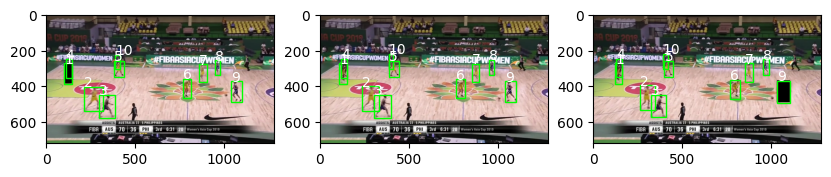

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(10,3))

for i_batch, (img,y) in enumerate(whole_dataloader):
  if i_batch>0:
    break
  for idx,(single_img,single_y) in enumerate(zip(img,y)):
    axs[idx].imshow(single_img.permute(1,2,0))
    for bbox, label in zip(single_y["boxes"],single_y["labels"]):
        x = bbox[0]
        y = bbox[1]
        w = bbox[2] - bbox[0]
        h = bbox[3] - bbox[1]
        rect = Rectangle((x,y),w,h,fc='None',ec='lime',lw=1)
        axs[idx].add_patch(rect)
        axs[idx].text(x, y, label.item(), color='white')

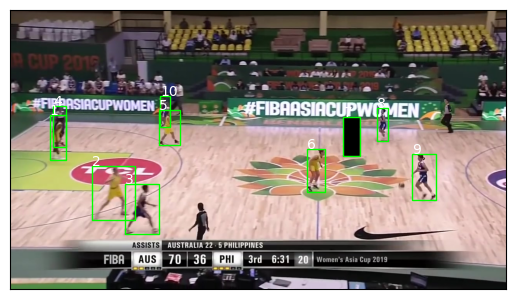

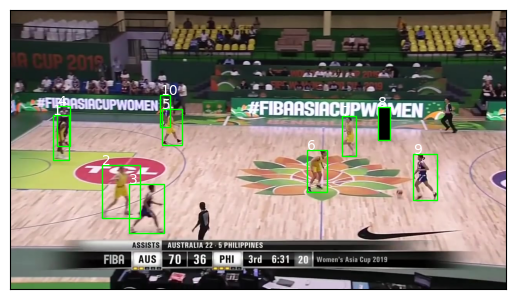

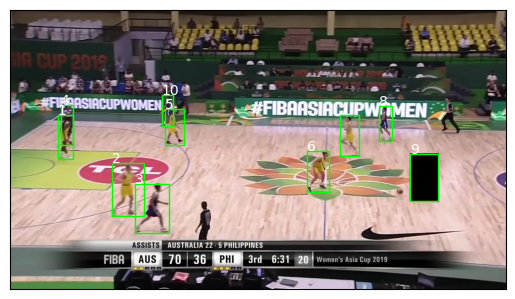

In [ ]:
for i_batch, (img,y) in enumerate(whole_dataloader):
  if i_batch>0:
    break
  for idx,(single_img,single_y) in enumerate(zip(img,y)):
    fig, ax = plt.subplots()
    ax.imshow(single_img.permute(1,2,0))
    for bbox, label in zip(single_y["boxes"],single_y["labels"]):
        x = bbox[0]
        y = bbox[1]
        w = bbox[2] - bbox[0]
        h = bbox[3] - bbox[1]
        rect = Rectangle((x,y),w,h,fc='None',ec='lime',lw=1)
        ax.add_patch(rect)
        ax.text(x, y, label.item(), color='white')
        ax.set_xticks([])
        ax.set_yticks([])

### Transform xy format to central x and central y format

In [ ]:
def xy_to_cxcy_box(xy_box):
    '''
    xy_box: xmin,ymin,xmax,ymax
    '''
    return torch.cat([(xy_box[:, 2:] + xy_box[:, :2]) / 2,  # c_x, c_y
                      xy_box[:, 2:] - xy_box[:, :2]], 1)  # w, h

### Extract time series

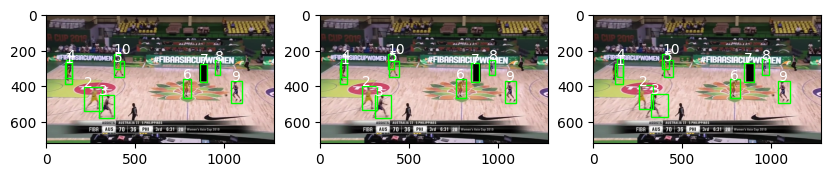

In [ ]:
cxcy = []
fig, axs = plt.subplots(1,3,figsize=(10,10))

for i_batch, (img,y) in enumerate(whole_dataloader):
  model.eval()
  with torch.no_grad():
    img = list(image.to(device) for image in img)
    # Get predictions
    predtions = model(img)
    for idx, pred in enumerate(predtions):
      _, idxs = np.unique(pred['labels'].detach().cpu(),return_index=True)
      boxes = pred['boxes'].detach().cpu()[idxs]
      labels = pred['labels'].detach().cpu()[idxs]

      # transform xy to cxcy
      cxcy_boxes = xy_to_cxcy_box(boxes)
      cxcy_points = pd.DataFrame(cxcy_boxes[:,:2], index = labels.numpy(), columns=['cx','cy'])
      cxcy.append(cxcy_points)

      if i_batch<1:
        axs[idx].imshow(img[0].cpu().permute(1,2,0))
        for bbox, label in zip(boxes,labels):
            x = bbox[0]
            y = bbox[1]
            w = bbox[2] - bbox[0]
            h = bbox[3] - bbox[1]
            rect = Rectangle((x,y),w,h,fc='None',ec='lime',lw=1)
            axs[idx].add_patch(rect)
            axs[idx].text(x, y, label.item(), color='white')

cxcy = pd.concat(cxcy,keys=range(len(dataset)))
cxcy.to_pickle('cxcy.pkl')

### Visualize time series

In [ ]:
pred_cxcy = pd.read_pickle('/content/drive/MyDrive/cxcy.pkl')
cx = pred_cxcy['cx'].to_numpy().reshape(1,-1,10)
cy = pred_cxcy['cy'].to_numpy().reshape(1,-1,10)

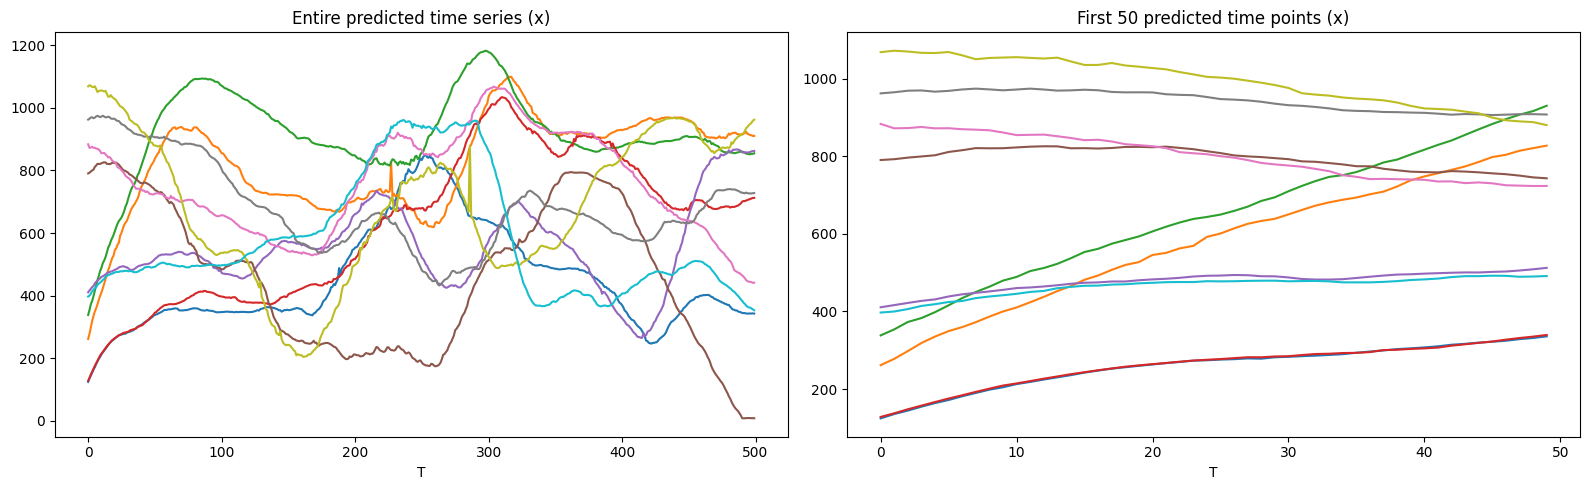

In [ ]:
# Plot x data
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(cx[0])
axarr[0].set_xlabel('T')
axarr[0].set_title('Entire predicted time series (x)')
axarr[1].plot(cx[0][:50])
axarr[1].set_xlabel('T')
axarr[1].set_title('First 50 predicted time points (x)')
plt.tight_layout()
plt.show()

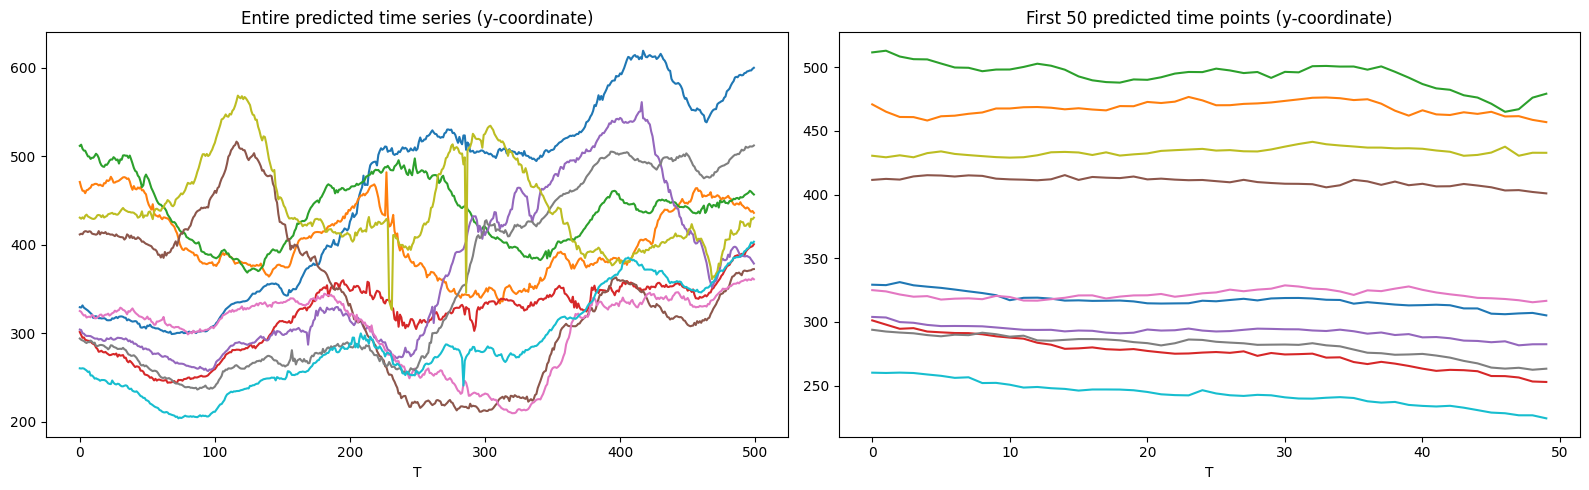

In [ ]:
# Plot y-coordinate data
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(cy[0])
axarr[0].set_xlabel('T')
axarr[0].set_title('Entire predicted time series (y-coordinate)')
axarr[1].plot(cy[0][:50])
axarr[1].set_xlabel('T')
axarr[1].set_title('First 50 predicted time points (y-coordinate)')
plt.tight_layout()
plt.show()

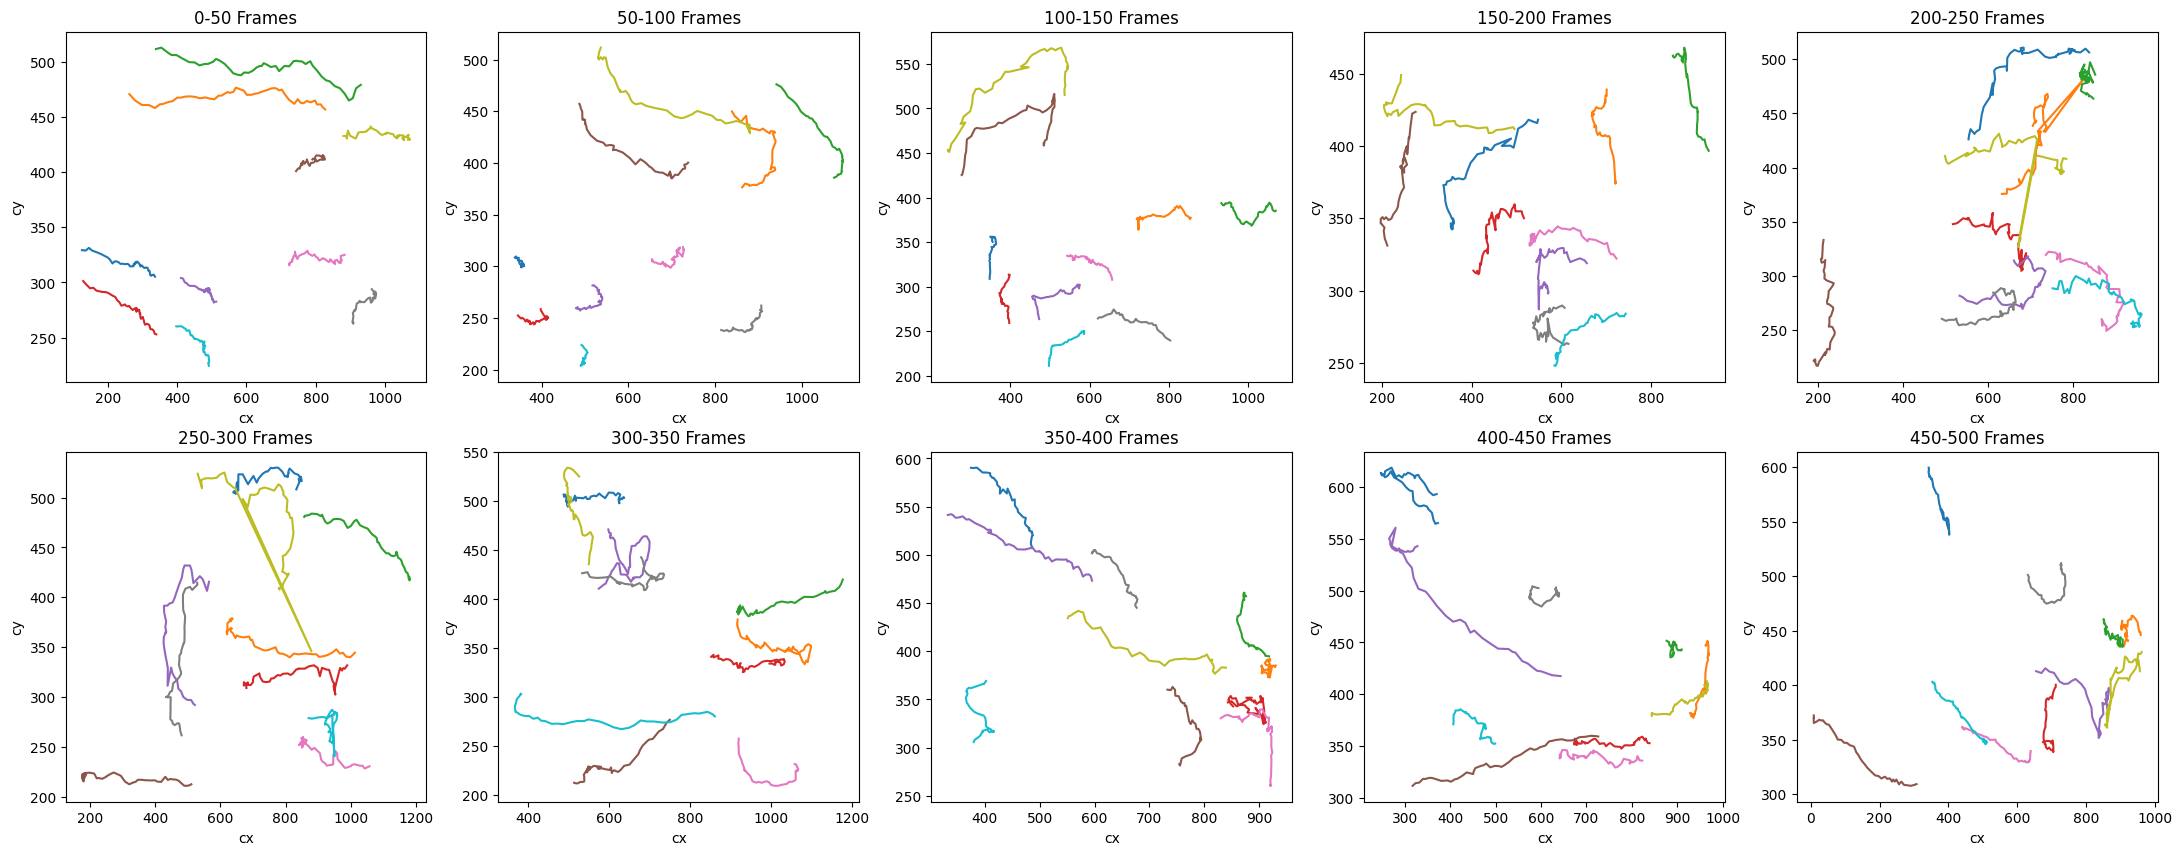

In [ ]:
# Plot 2-d coordinate changes
fig, axs = plt.subplots(2, 5, figsize=(27, 10))
for i in range(10):
    ax = axs[i//5,i%5]
    ax.plot(cx[0][i*50:(i+1)*50],cy[0][i*50:(i+1)*50])
    ax.set_xlabel('cx')
    ax.set_ylabel('cy')
    ax.set_title(f'{i*50}-{(i+1)*50} Frames')

### Download needed repository for causality discovery

In [ ]:
!git clone https://github.com/iancovert/Neural-GC.git

In [ ]:
import sys
sys.path.append('/content/Neural-GC')
from models.clstm import cLSTM, train_model_ista
# For GPU acceleration
device = torch.device('cuda')

## Causality discovery from true label for testing purpose

In [ ]:
# Load labels.
img_labels = pd.read_csv('/content/drive/MyDrive/v_-6Os86HzwCs_c009/gt/gt.txt', header=None) # ['frame', 'id', 'bb_left', 'bb_top','bb_width', 'bb_height', 'x', 'y', 'z']
img_labels.iloc[:,2] = img_labels.iloc[:,2] + img_labels.iloc[:,4]/2 # central x
img_labels.iloc[:,3] = img_labels.iloc[:,3] + img_labels.iloc[:,5]/2 # central y
columns = ['frame', 'id', 'cx', 'cy','w', 'h', 'x', 'y', 'z']
img_labels.columns = columns
img_labels.drop(['x','y','z'],inplace=True,axis=1)
# Interpolate missing labels.
img_labels = interpolate_label(img_labels)

In [ ]:
# Get cxcy
img_labels = img_labels.sort_values(['frame','id']).set_index('frame')
cx = img_labels['cx'].to_numpy().reshape(1,-1,10)
cy = img_labels['cy'].to_numpy().reshape(1,-1,10)

# array to tensor
cx = torch.tensor(cx, dtype=torch.float32, device=device)
cy = torch.tensor(cy, dtype=torch.float32, device=device)
cxcy = torch.concat([cx,cy],dim=0)

### Train cLSTM

In [ ]:
# Set up model
clstm_ture = cLSTM(cx.shape[-1], hidden=10).to(device=device)

# Train with ISTA
train_loss_list = train_model_ista(
    clstm_ture, cx, context=10, lam=10.0, lam_ridge=1e-2, lr=1e-3, max_iter=20000, lookback=60,
    check_every=50)

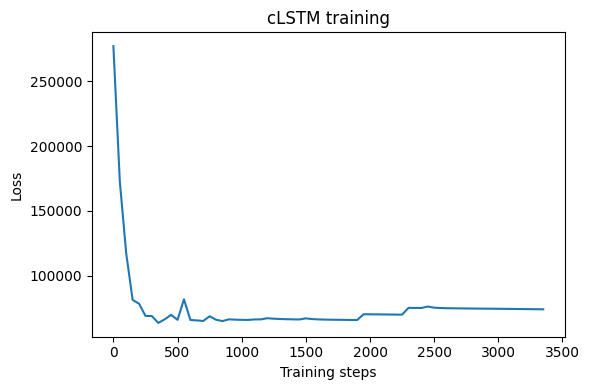

In [ ]:
# Loss function plot
plt.figure(figsize=(6, 4))
train_loss_list = [loss.to('cpu') for loss in train_loss_list]
plt.plot(50 * np.arange(len(train_loss_list)), train_loss_list)
plt.title('cLSTM training')
plt.ylabel('Loss')
plt.xlabel('Training steps')
plt.tight_layout()
plt.show()

### Granger Causality Matrix

In [ ]:
GC_true = clstm_ture.GC().cpu().data.numpy()

## Use predicted lables to train another cLSTM

In [ ]:
pred_img_labels = pd.read_pickle('/content/drive/MyDrive/cxcy.pkl')
cx = img_labels['cx'].to_numpy().reshape(1,-1,10)
cy = img_labels['cy'].to_numpy().reshape(1,-1,10)

# array to tensor
cx = torch.tensor(cx, dtype=torch.float32, device=device)
cy = torch.tensor(cy, dtype=torch.float32, device=device)
cxcy = torch.concat([cx,cy],dim=0)

In [ ]:
# Set up model
clstm_pred = cLSTM(cx.shape[-1], hidden=10).to(device=device)

# Train with ISTA
train_loss_list = train_model_ista(
    clstm_pred, cx, context=10, lam=10.0, lam_ridge=1e-2, lr=1e-3, max_iter=20000, lookback=60,
    check_every=50)

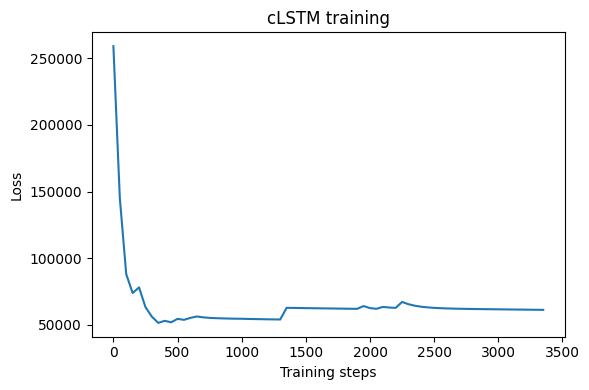

In [ ]:
# Loss function plot
plt.figure(figsize=(6, 4))
train_loss_list = [loss.to('cpu') for loss in train_loss_list]
plt.plot(50 * np.arange(len(train_loss_list)), train_loss_list)
plt.title('cLSTM training')
plt.ylabel('Loss')
plt.xlabel('Training steps')
plt.tight_layout()
plt.show()

### Predicted Granger Causality Matrix

In [ ]:
GC_pred = clstm_pred.GC().cpu().data.numpy()

## Compare true causality with predicted causality

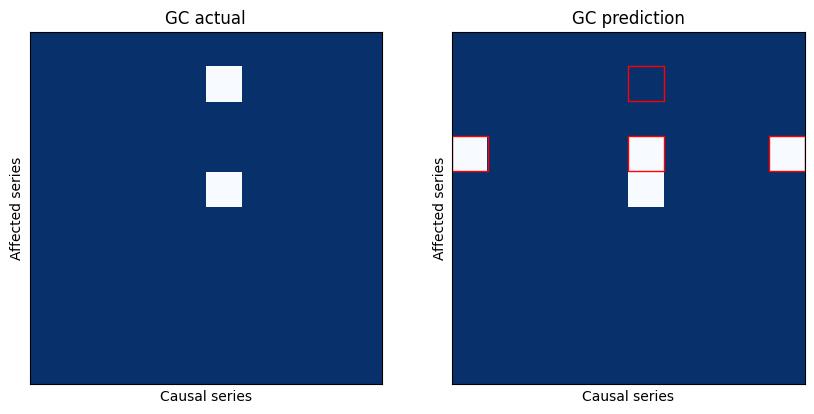

In [ ]:

# Make figures
fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
axarr[0].imshow(GC_true, cmap='Blues')
axarr[0].set_title('GC actual')
axarr[0].set_ylabel('Affected series')
axarr[0].set_xlabel('Causal series')
axarr[0].set_xticks([])
axarr[0].set_yticks([])

axarr[1].imshow(GC_pred, cmap='Blues', vmin=0, vmax=1, extent=(0, len(GC_pred), len(GC_pred), 0))
axarr[1].set_title('GC prediction')
axarr[1].set_ylabel('Affected series')
axarr[1].set_xlabel('Causal series')
axarr[1].set_xticks([])
axarr[1].set_yticks([])

# Mark disagreements
for i in range(len(GC_pred)):
    for j in range(len(GC_pred)):
        if GC_true[i, j] != GC_pred[i, j]:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[1].add_patch(rect)

plt.show()